In [44]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import itertools

# Loading challenge data

In [2]:
aes_key_prefix = bytearray.fromhex('97ca6080f575')

In [3]:
# Read the inputs into a list
f = open('test.txt', 'r') 
data = f.readlines()
f.close()

# Parse the list into numpy arrays
ntraces = len(data)
pt = np.zeros((ntraces, 16), dtype='uint8')
time = np.zeros((ntraces))

for idx, line in enumerate(data):
    data = line.strip().split((','))
    pt[idx] = bytearray.fromhex(data[0])
    time[idx] = int(data[1])

# Proof of Concept
## Recover key byte 4 given key byte 0

In [4]:
labels_ref = np.zeros((ntraces), dtype='uint8')
for i in range(ntraces):
    labels_ref[i] = pt[i,0] ^ aes_key_prefix[0]

In [5]:
labels_candidates = np.zeros((ntraces), dtype='uint8')
timediff = np.zeros((256))

for kguess in tqdm_notebook(range(256)):
    for i in range(ntraces):
        labels_candidates[i] = pt[i,4] ^ kguess
        
    collision_idx = np.where(labels_ref == labels_candidates)[0]
    timediff[kguess] = np.mean(np.delete(time, collision_idx)) - np.mean(time[collision_idx])

In [6]:
# Top 10 candidates according to the difference of means distinguisher
print(np.argsort(np.abs(timediff))[::-1][0:10])

# Known value of key byte 4
print('Key byte 4:', aes_key_prefix[4])

[245 247 244 246  13  43 184  50  83 211]
Key byte 4: 245


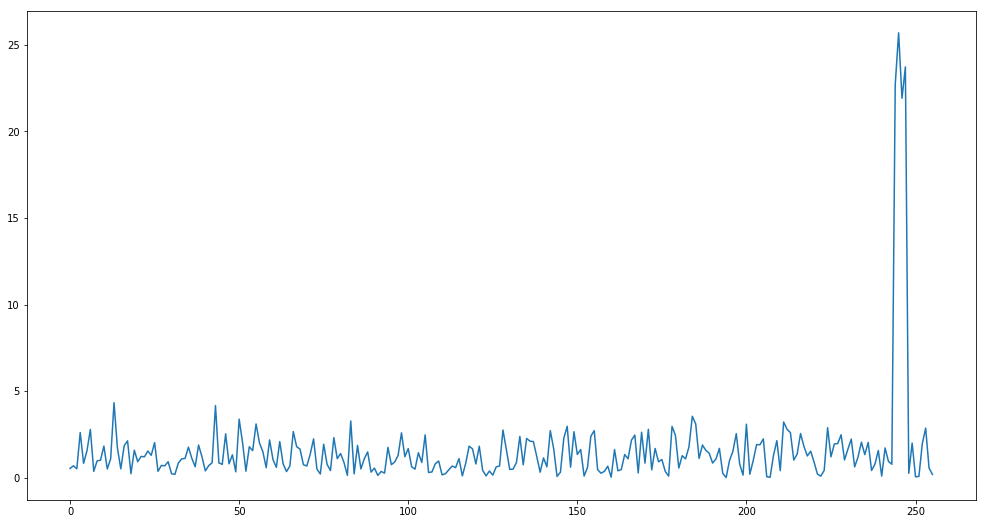

In [7]:
%matplotlib inline

fig, axs = plt.subplots(1, figsize=(17,9))
axs.plot(np.abs(timediff))

# Recovering key bytes
I ended up precomputing all of the possible labels for each key byte. This takes some time and is probably uneccessary but it made further analysis more covenient. This by no means the best or most efficient implementation.

In [8]:
labels_all = np.zeros((16, ntraces, 256), dtype='uint8')

for i in tqdm_notebook(range(ntraces)):
    for b in range(16):
        for k in range(256):
            labels_all[b,i,k] = pt[i][b] ^ k

In [31]:
def keysearch(l_ref, targets):
    timediff = np.zeros((256))
    
    for byte_target in targets:
        for k_t in range(256):
            l_tar = labels_all[byte_target,:,k_t]

            collision_idx = np.where(l_ref == l_tar)[0]
            timediff[k_t] = np.mean(np.delete(time, collision_idx)) - np.mean(time[collision_idx])

        if np.max(np.abs(timediff)) > 10:
            print('Found candidate values for key byte', byte_target)
            print(np.argsort(np.abs(timediff))[::-1][0:4], np.max(np.abs(timediff)))

In [32]:
l_ref_0 = labels_all[0,:,aes_key_prefix[0]]
l_ref_1 = labels_all[1,:,aes_key_prefix[1]]
l_ref_2 = labels_all[2,:,aes_key_prefix[2]]
l_ref_3 = labels_all[3,:,aes_key_prefix[3]]
l_ref_4 = labels_all[4,:,aes_key_prefix[4]]
l_ref_5 = labels_all[5,:,aes_key_prefix[5]]

keysearch(l_ref_0, [4,8,12])
keysearch(l_ref_4, [0,8,12])

keysearch(l_ref_1, [5,9,13])
keysearch(l_ref_5, [1,9,13])

keysearch(l_ref_2, [6,10,14])

keysearch(l_ref_3, [7,11,15])

Found candidate values for key byte 4
[245 247 244 246] 25.69425961338493
Found candidate values for key byte 0
[151 149 150 148] 25.69425961338493
Found candidate values for key byte 8
[228 231 230 229] 24.571021646042936
Found candidate values for key byte 9
[84 87 85 86] 26.273035208649162
Found candidate values for key byte 14
[104 105 107 106] 26.720041610802582
Found candidate values for key byte 7
[70 71 68 69] 25.926706003594518
Found candidate values for key byte 15
[94 92 93 95] 24.1392416807048


Using the first 6 key bytes which are provided as part of the challenge we are able to recover candidates for 5 additional bytes. We can use these newly recovered bytes to try and recover some of the remaining key bytes.

In [33]:
l_ref_7 = labels_all[7,:,70]
l_ref_8 = labels_all[8,:,228]
l_ref_9 = labels_all[9,:,84]
l_ref_14 = labels_all[14,:,104]
l_ref_15 = labels_all[15,:,94]


keysearch(l_ref_7, [11])
keysearch(l_ref_8, [12])
keysearch(l_ref_9, [13])
keysearch(l_ref_14, [6,10])
keysearch(l_ref_15, [11])

Found candidate values for key byte 13
[21 23 22 20] 25.215723463183167
Found candidate values for key byte 10
[247 244 245 246] 23.448650093516335


In [34]:
l_ref_10 = labels_all[10,:,244]
keysearch(l_ref_10, [2,6,14])

Found candidate values for key byte 14
[107 104 105 106] 23.448650093516335


At this point we have candidates for all but three bytes of the secret key!
This leaves us with 2^38 key candidates. It would be reasonable to attempt a brute force at this point using [Hulk](https://github.com/SideChannelMarvels/Hulk) from the Side-Channel Marvels.

Before doing so I decided to try and recover any key byte using any of the known key bytes (even though I did not expect this to work).

|Key byte|candidates|
|--------|----------|
|0|0x97|
|1|0xCA|
|2|0x60|
|3|0x80|
|4|0xF5|
|5|0x75|
|6||
|7|0x46, 0x47, 0x44, 0x45|
|8|0xE4, 0xE7, 0xE6, 0xE5|
|9|0x54, 0x57, 0x55, 0x56|
|10|0xF4, 0xF5, 0xF7, 0xF6|
|11||
|12||
|13|0x15, 0x17, 0x16, 0x14|
|14|0x68, 0x69, 0x6B, 0x6A|
|15|0x5E, 0x5C, 0x5D, 0x5F|

In [38]:
l_ref_0 = labels_all[0,:,aes_key_prefix[0]]
l_ref_1 = labels_all[1,:,aes_key_prefix[1]]
l_ref_2 = labels_all[2,:,aes_key_prefix[2]]
l_ref_3 = labels_all[3,:,aes_key_prefix[3]]
l_ref_4 = labels_all[4,:,aes_key_prefix[4]]
l_ref_5 = labels_all[5,:,aes_key_prefix[5]]
l_ref_7 = labels_all[7,:,70]
l_ref_8 = labels_all[8,:,228]
l_ref_9 = labels_all[9,:,84]
l_ref_10 = labels_all[10,:,247]
l_ref_13 = labels_all[13,:,21]
l_ref_14 = labels_all[14,:,104]
l_ref_15 = labels_all[15,:,94]


print('Using byte 0 as reference')
keysearch(l_ref_0, range(16))

print('\nUsing byte 1 as reference')
keysearch(l_ref_1, range(16))

print('\nUsing byte 2 as reference')
keysearch(l_ref_2, range(16))

print('\nUsing byte 3 as reference')
keysearch(l_ref_3, range(16))

print('\nUsing byte 4 as reference')
keysearch(l_ref_4, range(16))

print('\nUsing byte 5 as reference')
keysearch(l_ref_5, range(16))

print('\nUsing byte 7 as reference')
keysearch(l_ref_7, range(16))

print('\nUsing byte 8 as reference')
keysearch(l_ref_8, range(16))

print('\nUsing byte 9 as reference')
keysearch(l_ref_9, range(16))

print('\nUsing byte 10 as reference')
keysearch(l_ref_10, range(16))

print('\nUsing byte 13 as reference')
keysearch(l_ref_13, range(16))

print('\nUsing byte 14 as reference')
keysearch(l_ref_14, range(16))

print('\nUsing byte 15 as reference')
keysearch(l_ref_15, range(16))

Using byte 0 as reference
Found candidate values for key byte 4
[245 247 244 246] 25.69425961338493

Using byte 1 as reference
Found candidate values for key byte 10
[244 245 247 246] 23.53293628602114

Using byte 2 as reference
Found candidate values for key byte 14
[104 105 107 106] 26.720041610802582

Using byte 3 as reference
Found candidate values for key byte 7
[70 71 68 69] 25.926706003594518
Found candidate values for key byte 15
[94 92 93 95] 24.1392416807048

Using byte 4 as reference
Found candidate values for key byte 0
[151 149 150 148] 25.69425961338493
Found candidate values for key byte 8
[228 231 230 229] 24.571021646042936

Using byte 5 as reference
Found candidate values for key byte 9
[84 87 85 86] 26.273035208649162
Found candidate values for key byte 12
[188 190 189 191] 26.651998177509086

Using byte 7 as reference
Found candidate values for key byte 3
[128 129 130 131] 25.926706003594518

Using byte 8 as reference
Found candidate values for key byte 4
[245 246 2

The above cell was a "Hail Mary" attempt but it did provide us with new candidates for key bytes 6 and 12. I was not certain if these candidates were valid or why byte 15 would help to recover byte 6. However, looking at the results using byte 10 as the reference we see it also finds candidates for key byte 1, and the correct value for key byte 1 is included in those cadidates.

Assuming all of the above candidates are correct we are now left with only one unknown byte and about 2^26 possible keys remain.

|Key byte|candidates|
|--------|----------|
|0|0x97|
|1|0xCA|
|2|0x60|
|3|0x80|
|4|0xF5|
|5|0x75|
|6|0xE6, 0xE4, 0xE5, 0xE7|
|7|0x46, 0x47, 0x44, 0x45|
|8|0xE4, 0xE7, 0xE6, 0xE5|
|9|0x54, 0x57, 0x55, 0x56|
|10|0xF4, 0xF5, 0xF7, 0xF6|
|11||
|12|0xBC, 0xBE, 0xBD, 0xBF|
|13|0x15, 0x17, 0x16, 0x14|
|14|0x68, 0x69, 0x6B, 0x6A|
|15|0x5E, 0x5C, 0x5D, 0x5F|


# Key recovery

By now the key space has been greatly reduced, there is no reason to use fancy key enumeration algorithms, optimised brute forcing tools or even multiple cores.

We can use the first block of the encrypted flag in combination with the known start sequence to recover the full key and decrypt the flag.

In [47]:
flag_ct = bytearray.fromhex('7972c157dad7b858596ecdb798877cc4ed4b03d6822295954e69b7ecebb704af08c054a03a374f8bdaa18ff16ba09be2b6b25f1ef73ef80111646de84cd3af2514501e056889e95c680f7d199b6531e9dd6ee599aeb23835327e6e853a9a40a9f405bd1443e014363ea46631582b97c3d3f83f4e1101da2557f9b03808a61968')
ct_bf = flag_ct[0:16]

In [48]:
_11 = range(256)
_6 = [0xE6, 0xE4, 0xE5, 0xE7]
_7 = [0x46, 0x47, 0x44, 0x45]
_8 = [0xE4, 0xE7, 0xE6, 0xE5]
_9 = [0x54, 0x57, 0x55, 0x56]
_10 = [0xF4, 0xF5, 0xF7, 0xF6]
_12 = [0xBC, 0xBE, 0xBD, 0xBF]
_13 = [0x15, 0x17, 0x16, 0x14]
_14 = [0x68, 0x69, 0x6B, 0x6A]
_15 = [0x5E, 0x5C, 0x5D, 0x5F]

In [49]:
%%time
for i in itertools.product(_6,_7,_8,_9,_10,_11,_12,_13,_14,_15):
    key = aes_key_prefix + bytearray(i)
    cipher = AES.new(key, AES.MODE_ECB)
    pt = cipher.decrypt(ct_bf)
    if pt == b'flag{uniform5434':
        print('Key recovered:', key.hex())
        break

Key recovered: 97ca6080f575e646e557f755bf15685e
CPU times: user 54.2 s, sys: 31.9 ms, total: 54.3 s
Wall time: 54.3 s


## Decrypt the flag

In [50]:
cipher = AES.new(key, AES.MODE_ECB)
pt = unpad(cipher.decrypt(flag_ct), 16)
print(pt)

b'flag{uniform54349juliet:GL2aGs7ys8ygcW0kFBPLbwEdjLbwNltiPdX_ANqtOFbUpEh_ciY8tWZd4y2VblkUhOl-PxXJdJYK86pIHmmwcw0}'
